In [1]:
DATA_DIR = '/scratch/groups/rubin/rvignav/input/train/'
balanced = True
pref = 'balanced_notstylized_btg_aug_norm'
WEIGHT_FILE = '/scratch/groups/rubin/' + pref + '_'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import time
from PIL import Image
import glob
from torchsummary import summary
from collections import OrderedDict

/scratch/groups/rubin/rvignav/input/train/17627_right.jpeg


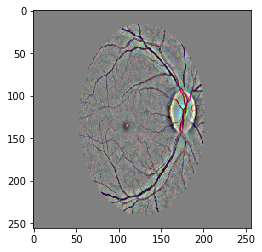

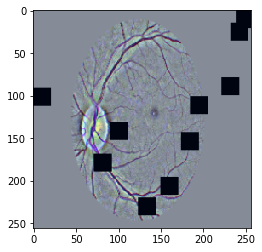

/scratch/groups/rubin/rvignav/input/train/25956_right.jpeg


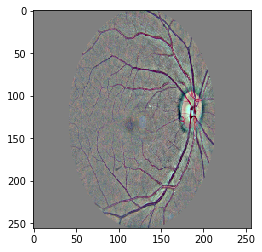

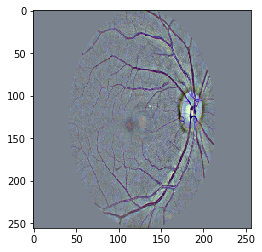

/scratch/groups/rubin/rvignav/input/train/31089_right.jpeg


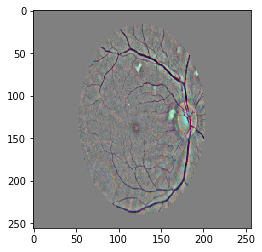

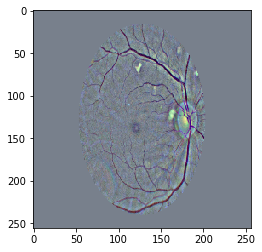

/scratch/groups/rubin/rvignav/input/train/3031_right.jpeg


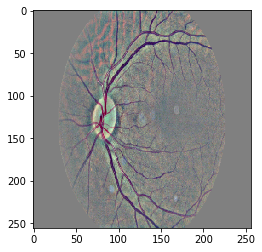

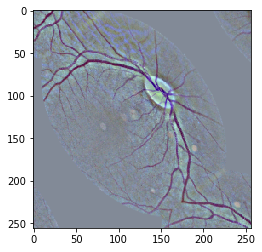

/scratch/groups/rubin/rvignav/input/train/7304_left.jpeg


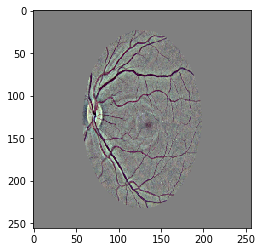

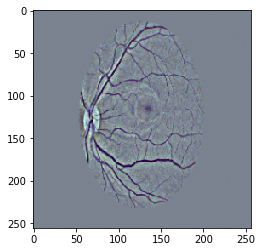

In [3]:
l = glob.glob(DATA_DIR + '*.jpeg')

def scaleRadius(img, scale):
  x = img[int(img.shape[0]/2), :, :].sum(1)
  r = (x>x.mean()/10).sum()/2
  s = scale*1.0/r
  return cv2.resize(img, (0,0), fx=s, fy=s)

def renormalize(tensor):
  minFrom= tensor.min()
  maxFrom= tensor.max()
  minTo = 0
  maxTo = 1
  return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

l = glob.glob(DATA_DIR + '*.jpeg')

t = A.Compose([
        A.Resize(256, 256), 
        A.RandomCrop(height=243, width=243, p=0.5),
        A.GaussNoise(var_limit=[0.0, 0.07], mean=0, p=0.5),
        A.ColorJitter(p=0.5),
        A.Flip(p=0.5),
        A.Cutout(num_holes=10, max_h_size=20, max_w_size=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, 
                           border_mode=cv2.BORDER_REFLECT_101, p=0.5),
        A.Resize(256, 256),    
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ])

for i in range(5):
    a = cv2.imread(l[i])
    print(l[i])
    
    scale = 300
    a = cv2.imread(l[i])
    a = scaleRadius(a, scale)
    a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0), scale/30), -4, 128)
    b = np.zeros(a.shape)
    cv2.circle(b, (int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9), (1, 1, 1), -1, 8, 0)
    a = a*b+128*(1-b)

    a = cv2.resize(a, (256,256))
    plt.imshow(cv2.cvtColor(a.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.show()

    image = a.astype('uint8')

    a = t(image=image)["image"]   
    a = a.permute(1, 2, 0)
    a = renormalize(a)
        
    plt.imshow(a)
    plt.show()

In [4]:
def check_cuda():
    is_cuda = False
    if torch.cuda.is_available():
        is_cuda = True
    return is_cuda

class DRDataset(Dataset):
    def __init__(self, csv_path):
        self.data_info = pd.read_csv(csv_path, header=None)
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):     
        single_image_name = DATA_DIR + self.image_arr[index] + '.jpeg'
        a = cv2.imread(single_image_name)
        
        scale = 300
        a = cv2.imread(l[i])
        a = scaleRadius(a, scale)
        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0), scale/30), -4, 128)
        b = np.zeros(a.shape)
        cv2.circle(b, (int(a.shape[1]/2), int(a.shape[0]/2)), int(scale*0.9), (1, 1, 1), -1, 8, 0)
        a = a*b+128*(1-b)

        a = cv2.resize(a, (256,256))

        image = a.astype('uint8')
        img_as_tensor = t(image=image)["image"]
                
        single_image_label = self.label_arr[index]
        if single_image_label != 0:
            single_image_label = 1

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len
    
if balanced:
    train_dataset = DRDataset('/home/users/rvignav/train_balanced.csv')
    val_dataset = DRDataset('/home/users/rvignav/val_balanced.csv')
else:
    train_dataset = DRDataset('/home/users/rvignav/train_imbalanced.csv')
    val_dataset = DRDataset('/home/users/rvignav/val_imbalanced.csv')
    
print("Train: " + str(len(train_dataset)))
print("Val: " + str(len(val_dataset)))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory=True)

valid_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory=True)

Train: 13030
Val: 1448


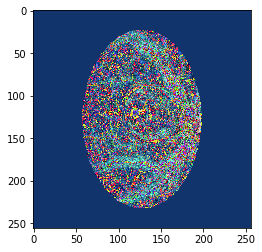

tensor(1): DR


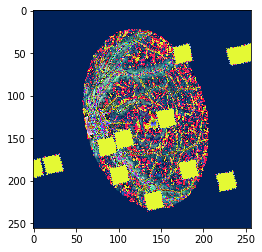

tensor(1): DR


In [5]:
classes = ['no DR', 'DR']

for data, target in train_data_loader:
    for i in range(0, 2):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)), cmap='gray')
        plt.show()
        print(str(target[i]) + ": " + classes[(int)(target[i])])
    break

In [ ]:
model = models.resnet50(pretrained=True, progress=False)
model.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.5)), #0.337
                           ('fc2', nn.Linear(512, 1)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))

is_cuda = check_cuda()
if is_cuda:
    model.cuda()
    
print(summary(model, (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def validate(model, valid_data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_data_loader:
            images, labels = data
            images = np.array(images, int) 
            images = torch.Tensor(images).float()
            labels = np.array(labels, int) 
            labels = torch.Tensor(labels).long()
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

num_epochs = 5

criterion = nn.BCEWithLogitsLoss() #CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
for epoch in tqdm(range(num_epochs)): 
    running_loss = 0.0
    e_acc = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data
        inputs = np.array(inputs, int) 
        inputs = torch.Tensor(inputs).float()
        labels = np.array(labels, int) 
        labels = torch.Tensor(labels).float()
        inputs, labels = inputs.cuda(), labels.cuda()
        labels = labels.unsqueeze(1)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = binary_acc(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        e_acc += acc.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f | acc: %.3f' % (epoch + 1, i + 1, running_loss / 100, e_acc / 100))
            running_loss = 0.0
            e_acc = 0.0
    
    torch.save(model, WEIGHT_FILE + str(epoch+1) + 'epochs')
    
#     print("train_acc: " + str(validate(model, train_data_loader)))
    print("val_acc: " + str(validate(model, valid_data_loader)))
    
print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

[1,     1] loss: 0.007 | acc: 0.380
[1,   101] loss: 0.693 | acc: 37.140
[1,   201] loss: 0.693 | acc: 35.030
[1,   301] loss: 0.693 | acc: 36.550
[1,   401] loss: 0.693 | acc: 34.770


 20%|██        | 1/5 [52:24<3:29:37, 3144.30s/it]

val_acc: 34.73756906077348
[2,     1] loss: 0.007 | acc: 0.380
[2,   101] loss: 0.693 | acc: 35.220
[2,   201] loss: 0.693 | acc: 35.070
[2,   301] loss: 0.693 | acc: 35.810
[2,   401] loss: 0.693 | acc: 36.860


 40%|████      | 2/5 [2:21:43<3:42:22, 4447.43s/it]

val_acc: 34.73756906077348
[3,     1] loss: 0.007 | acc: 0.560
[3,   101] loss: 0.693 | acc: 33.880
[3,   201] loss: 0.693 | acc: 37.280


In [ ]:
# torch.save(model, WEIGHT_FILE + 'FINAL')

In [ ]:
y_true = []
y_pred = []
y_tot = []

classes = ['no DR', 'DR']
with torch.no_grad():
    for data in valid_data_loader:
        images, labels = data
        images = np.array(images, int) 
        images = torch.Tensor(images).float()
        labels = np.array(labels, int) 
        labels = torch.Tensor(labels).long()
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        sm = torch.nn.Softmax()
        probs = sm(outputs)
        for i in range(len(labels)):
            y_true.append(int(labels[i].item()))
            y_pred.append(int(predicted[i].item()))
            y_tot.append(probs[i].cpu().numpy())

# np.savetxt('/home/users/rvignav/y_true_' + pref + '.csv', np.asarray(y_true), delimiter=',')
# np.savetxt('/home/users/rvignav/y_tot_' + pref + '.csv', np.asarray(y_tot), delimiter=',')

# print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

print(quadratic_weighted_kappa(y_true, y_pred))